# The Rapid Transport Model for London

Although, the rapid tranport method can apply arbitrary model, we use SEAIR model here.
The dynamical equations are given as

\begin{align}
\dot{S_{in}}	    &=-\lambda_{in}(t)S_{in}+\sigma_{in},\\
\dot{E}_{in}	    &=\lambda_{in}(t)S_{in}-\gamma_{E}E_{in},\\
\dot{A}_{in}	    &=\gamma_{E}E_{in}-\gamma_{A}A_{in},\\
\dot{I}_{in}        &=\gamma_{A}A_{in}-\gamma_{I}I_{in},\\
\dot{R}_{in}        &=\gamma_{I}I_{in}.\\
\end{align}


In [1]:
import numpy as np
import pyrossgeo
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import math
import os
import sys
import gc

In this notebook, we perform the rapid transport model.
The key idea of mean-field model is to note that the rate of infection of a susceptible individual in age group `i` at the node `n` is given as

\begin{align}
\lambda_{in}(t)=\lambda^0_{in}(t)=\beta\sum_{j=1}^{M}C_{ij}\frac{A_{jn} + I_{jn}^{s}}{N^{H}_{jn}},
\end{align}


Commute can then be modeled by changing this to


\begin{align}
\lambda_{in}^{T}(t)=\beta r^{T}\sum_{j=1}^{M}\sum_{m=1}^{N_{d}} \sum_{<k,l>} C_{ij} \frac{D_{j,kl}}{N^{H}_{j,l}} \frac{A_{jl} + I_{jl}}{N^{T}_{j,mn}} \frac{D_{i,mn}}{N^{H}_{i,n}},
\end{align}


while workplace interaction can be modeled as


\begin{align}
\lambda_{in}^{W}(t)=\beta r^{W}\sum_{j=1}^{M}\sum_{m,k=1}^{N_{d}} C_{ij} \frac{D_{j,mk}}{N^{H}_{jk}} \frac{A_{jk} + I_{jk}}{N^{W}_{jm}}  \frac{D_{i,mn}}{N^{H}_{in}}.
\end{align}

The derivation of all equations is wrriten in [the documentation](https://github.com/lukastk/PyRossGeo/tree/master/docs/mft-model.pdf).
The simulation then runs by choosing appropriate $\lambda$ as a function of time. The constants $r_T$ and $r_W$ control the strength of interactions. In this model, we assume that each route between the nodes connectsneighbour nodes only.

The defiintion of the variables are in following.
$D_{i,nm}$ is the number of people working at node `n` and livingin `m` in the age group `i`, $N^{H}_{in}=\sum_{m} D_{i,mn}$ is the total number of residence in node `n` and $N^{W}_{in}=\sum_{m} D_{i,nm}$ is the total number of people working at node `n`.
$N_{i,nm}^{T}$ is the effective number of the commuter in the age group `i` using the route between `n` and `m`:

\begin{align}
N^{T}_{i,nm}=\sum_{<kl>}R_{i,kl}\frac{d_{kl}}{d_{nm}},
\end{align}

where $<kl>$ indicate summation of all pair of neighbour node $k$ and $l$ included in the shortest path between node 
`n` and `m` and $d_{nm}$ is the distance between node `n` and `m` along the shortest path. $R_{i,nm}=\sum_{<kl>}D_{i,kl}$ is the number of the commuter in the age group `i` using the route between the neighbor node `n` and `m`. The node `n` and `m` are included in the shortest path between node pair 
$(k,l)$ took up all combinations satisfying the conditions.
Hence, we only need $D_{i,nm}$ and $d_{nm}$ in order to construct this network model. $D_{i,nm}$ can be obtained census datasets and $d_{nm}$ can be determined by the geographical locations. For the calculation of London including 983 nodes, $D_{i,nm}$ and $d_{nm}$ are stored CSV files.

Loading $D_{i,nm}$ from csv files.

In [2]:
M = 9 #Aged Group

sim_config_path = 'london_simulation'
#sim_config_path = 'london_simulation'
tot_pop = pd.read_csv("%s/node_populations.csv" % sim_config_path)
#tot_pop.head()
CSV_Nh = tot_pop.values
Nd = len(tot_pop) # The number of nodes

Nh = np.zeros((M + 1,Nd)) # The population of ususal residence
for i in range(Nd):
    for alp in range(M):
        Nh[alp,i] = CSV_Nh[i,alp + 2]

cn = pd.read_csv("%s/commuter_networks.csv" % sim_config_path, usecols=["Home", "From", "To", "Age", "# to move"])
#cn.head()
CSV_Dnm = cn.values

ii16 = np.iinfo(np.uint16)
Dnm_Max = np.amax(CSV_Dnm[:,4])
print('Max Dnm', Dnm_Max)
if ii16.max < Dnm_Max:
      print('Dnm is too large to calculate.')

census_matrix = np.zeros((M, Nd, Nd), dtype=np.uint16)
for i in range(len(CSV_Dnm)):
    if CSV_Dnm[i,0] == CSV_Dnm[i,1]:
        census_matrix[CSV_Dnm[i,3], CSV_Dnm[i,2], CSV_Dnm[i,0]] = CSV_Dnm[i,4]
        
for alp in range(M):
    for i in range(Nd): # Home node
        census_matrix[alp,i,i] = Nh[alp,i] - np.sum(census_matrix[alp,:,i])
        
del tot_pop
del CSV_Nh
del cn
del CSV_Dnm
gc.collect()

Max Dnm 1064


0

Loading $d_{nm}$ from distances.txt

In [3]:
distances=np.ones((Nd, Nd))
    
#Make Total
#for i in range(Nd):
#    for j in range(Nd):
#        #for alp in range(M):
#        census_matrix[M,i,j] = np.sum(census_matrix[:,i,j])
                
Nh = np.zeros((M + 1,Nd)) # The population of ususal residence
Nw = np.zeros((M + 1,Nd)) # The number of people working in specific node.
for alp in range(M):
    for i in range(Nd):
        #Nh[alp,i] = 0.
        #Nw[alp,i] = 0.
        #for j in range(Nd):
        Nh[alp,i] = np.sum(census_matrix[alp,:,i])
        Nw[alp,i] = np.sum(census_matrix[alp,i,:])
#for alp in range(M):
for i in range(Nd):
    Nh[M,i] = np.sum(Nh[:,i]) ## N^{H}_{i} residence in Node i
    Nw[M,i] = np.sum(Nw[:,i]) ## N^{W}_{i} working in Node i
        
# set the matarix D_{nm}
Dnm = census_matrix #.copy()

# set the matarix d_{nm}
dnm = distances #.copy()

max_wid = np.argsort(Nw[M])[Nd- 1]
print("Maxmimum City at Working", max_wid, Nw[M,max_wid])
max_rid = np.argsort(Nh[M])[Nd- 1]
print("Maxmimum City of Residence", max_rid, Nh[M,max_rid])
sorted_Nh = np.argsort(Nh[M])
for i in range(50):
    print('No.', i, sorted_Nh[Nd - 1 -i], Nh[M,sorted_Nh[Nd - 1 -i]])

Maxmimum City at Working 0 247971.0
Maxmimum City of Residence 701 24719.0
No. 0 701 24719.0
No. 1 859 19295.0
No. 2 750 16014.0
No. 3 305 15987.0
No. 4 935 15803.0
No. 5 356 15619.0
No. 6 120 15512.0
No. 7 350 14917.0
No. 8 554 14705.0
No. 9 725 14639.0
No. 10 742 14571.0
No. 11 51 14564.0
No. 12 307 14424.0
No. 13 250 14100.0
No. 14 973 14086.0
No. 15 779 13940.0
No. 16 354 13907.0
No. 17 641 13907.0
No. 18 751 13896.0
No. 19 266 13826.0
No. 20 931 13548.0
No. 21 843 13538.0
No. 22 891 13529.0
No. 23 543 13412.0
No. 24 627 13402.0
No. 25 967 13345.0
No. 26 780 13300.0
No. 27 722 13279.0
No. 28 500 13185.0
No. 29 852 13074.0
No. 30 977 13046.0
No. 31 580 12980.0
No. 32 271 12935.0
No. 33 845 12854.0
No. 34 522 12808.0
No. 35 114 12693.0
No. 36 70 12687.0
No. 37 213 12670.0
No. 38 835 12635.0
No. 39 461 12625.0
No. 40 731 12611.0
No. 41 976 12599.0
No. 42 106 12564.0
No. 43 501 12554.0
No. 44 547 12540.0
No. 45 875 12367.0
No. 46 18 12329.0
No. 47 734 12279.0
No. 48 301 12239.0
No. 49 

### Contact matrices

Define the contact matrices

In [4]:
C_home = np.array( [
    [5.0,4.83,4.69,4.58,4.48,4.4,4.33,4.28,4.23],
    [4.83,5.0,4.83,4.69,4.58,4.48,4.4,4.33,4.28],
    [4.69,4.83,5.0,4.83,4.69,4.58,4.48,4.4,4.33],
    [4.58,4.69,4.83,5.0,4.83,4.69,4.58,4.48,4.4],
    [4.48,4.58,4.69,4.83,5.0,4.83,4.69,4.58,4.48],
    [4.4,4.48,4.58,4.69,4.83,5.0,4.83,4.69,4.58],
    [4.33,4.4,4.48,4.58,4.69,4.83,5.0,4.83,4.69],
    [4.28,4.33,4.4,4.48,4.58,4.69,4.83,5.0,4.83],
    [4.23,4.28,4.33,4.4,4.48,4.58,4.69,4.83,5.0],
] )
    
C_school = np.array( [
    [8.0,7.83,7.69,0.25,0.19,0.15,0.12,0.1,0.09],
    [7.83,8.0,7.83,0.26,0.19,0.15,0.12,0.1,0.09],
    [7.69,7.83,8.0,0.26,0.19,0.15,0.12,0.11,0.09],
    [0.25,0.26,0.26,0.27,0.2,0.15,0.13,0.11,0.09],
    [0.19,0.19,0.19,0.2,0.2,0.16,0.13,0.11,0.09],
    [0.15,0.15,0.15,0.15,0.16,0.16,0.13,0.11,0.09],
    [0.12,0.12,0.12,0.13,0.13,0.13,0.13,0.11,0.1],
    [0.1,0.1,0.11,0.11,0.11,0.11,0.11,0.11,0.1],
    [0.09,0.09,0.09,0.09,0.09,0.09,0.1,0.1,0.1]
])

C_work = np.array( [
    [0.08,0.07,0.07,0.07,0.07,0.07,0.07,0.07,0.07],
    [0.07,0.09,0.08,0.08,0.08,0.08,0.08,0.08,0.08],
    [0.07,0.08,0.1,0.1,0.09,0.09,0.09,0.09,0.09],
    [0.07,0.08,0.1,0.12,0.12,0.11,0.11,0.11,0.11],
    [0.07,0.08,0.09,0.12,0.15,0.15,0.14,0.14,0.14],
    [0.07,0.08,0.09,0.11,0.15,0.2,0.19,0.19,0.19],
    [0.07,0.08,0.09,0.11,0.14,0.19,6.0,5.83,5.69],
    [0.07,0.08,0.09,0.11,0.14,0.19,5.83,6.0,5.83],
    [0.07,0.08,0.09,0.11,0.14,0.19,5.69,5.83,6.0]
])

C_transport = np.array( [
    [10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0],
    [10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0],
    [10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0],
    [10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0],
    [10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0],
    [10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0],
    [10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0],
    [10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0],
    [10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0]
])

contact_matrices = {
    'C' : C_home + C_school + C_work,
    'C_commute' : C_transport
}

Setting parameters

In [5]:
# set the contact structure
CH = C_home + C_school + C_work
CT = C_transport
CW = C_home + C_school + C_work
        
# parameters, which should be inffered
alpha = 0.0             # fraction of asymptomatic infectives
beta  = 0.02/24.0       # infection rate
gE    = 1.0/3.0/24.0    # recovery rate of exposed
gIa   = 0.1/24          # recovery rate of asymptomatic infectives 
gIs   = 1.0/3.0/24.0    # recovery rate of symptomatic infectives 
gIh   = 1.0/3.0/24.0    # recovery rate of hospitalized infectives 
gIc   = 0.1/24          # recovery rate of ICU infectives 
fsa   = 1.0             # the self-isolation parameter
fh    = 1.0             # the hospitalized-isolation parameter
rW    = 0.7             # the intercation controle in WORK
rT    = 1.0             # the intercation controle in TRANS
hh    = 1.0             # fraction of hospitalized infectives
cc    = 0.0             # fraction of ICU infectives
mm    = 0.0             # fraction of Im infectives

cutoff    = 10 # We ignore D_{i,nm}, when It is less than the vule of cutoff.
highspeed = 1           # the flag of highspeed  calculation. but not accurate
trv_restriction = 0.0   # travel restriction: 1.0 means everyone stay home

max_wid = np.argsort(Nw[M])[Nd- 1]
#print("Maxmimum City at Working", max_wid)
max_rid = np.argsort(Nh[M])[Nd- 1]
#print("Maxmimum City of Residence", max_rid)
min_wid = np.argsort(Nw[M])[0]
#print("Minimum City at Working", min_wid)
min_rid = np.argsort(Nh[M])[0]
#print("Minimum City of Residence", min_rid)

M1 = Nd*M
E_0 = np.zeros((M1))
Is_0 = np.zeros((M1))# We use Is instead of A 
Ia_0 = np.zeros((M1))
Ih_0 = np.zeros((M1))# We use Ih instead of I
Ic_0 = np.zeros((M1))
Im_0 = np.zeros((M1))
#seed_pop = [
#    (0, 1, 'E', 100),      # Home, age group, model class, seed quantity
#    (10, 2, 'E', 100),      
#    (23, 0, 'E', 100),     
#    (622, 4, 'E', 100),
#    (232, 4, 'E', 100)
#]
s_num = 100
E_0[1*Nd + 0]   += s_num
E_0[2*Nd + 10]  += s_num
E_0[0*Nd + 23]  += s_num
E_0[4*Nd + 622] += s_num
E_0[4*Nd + 232] += s_num
#Is_0[min_wid] += 10
R_0 = np.zeros((M1))
N_0 = np.zeros((M1))
for alp in range(M):
    for i in range(Nd):
        N_0[Nd*alp + i] = Nh[alp,i]
S_0  = N_0 - (Ia_0 + Is_0 + R_0)
print("Maximum R", Nh[M,max_rid], Nw[M,max_rid])
print("Maximum w", Nh[M,max_wid], Nw[M,max_wid])
print("Minimum R", Nh[M,min_rid], Nw[M,min_rid])
print("Minimum w", Nh[M,min_wid], Nw[M,min_wid])

# the contact matrix
def contactMatrix(t):
    t_p_24 = t%24
    if t_p_24 < 8.0 or t_p_24 > 18.0:
        return CH
    elif t_p_24 > 9.0 and t_p_24 < 17.0:
        return CW
    else:
        return CT

# set the matarix D_{nm}
#Dnm = census_matrix.copy()

# set the matarix d_{nm}
#dnm = distances.copy()

# instantiate model
parameters = {'alpha':alpha, 'beta':beta, 'gE':gE, 'gIa':gIa, 'gIs':gIs, 'gIh':gIh, 'gIc':gIc, 'fsa':fsa, 'fh':fh, 'hh':hh, 'cc':cc, 'mm':mm, 'rW':rW, 'rT':rT}
model = pyrossgeo.mft.SEI5R(parameters, M, Nd, Dnm, dnm, trv_restriction, cutoff, highspeed)

Maximum R 24719.0 24436.0
Maximum w 8320.0 247971.0
Minimum R 5031.0 4920.0
Minimum w 5717.0 3356.0
#Start to calculate fixed variables
Nonzero element 50222/78269409 8302411.0
Max index J 1 976
Max index I 1 55
#Finish calculating fixed variables


After setting the parameters, the calculation of network model will be started. **The modern laptop can finish this calculation about 10 second.**

In [6]:
#beta  = 0.020/24.0
rW=0.5
#rT=1.0
# intialize the model
parameters = {'alpha':alpha, 'beta':beta, 'gE':gE, 'gIa':gIa, 'gIs':gIs, 'gIh':gIh, 'gIc':gIc, 'fsa':fsa, 'fh':fh, 'hh':hh, 'cc':cc, 'mm':mm, 'rW':rW, 'rT':rT}
model.initialize(parameters, trv_restriction)

# duration of simulation
Tf=24*100; Nf=0.25*Tf # Maximum time step equals as Tf/Nf
# simulate model
data=model.simulate(S_0, E_0, Ia_0, Is_0, Ih_0, Ic_0, Im_0, N_0, contactMatrix, Tf, Nf, Ti=0)

#Start to calculate fixed variables
Nonzero element 50222/78269409 8663275.0
Max index J 1 976
Max index I 1 55
#Finish calculating fixed variables
travel restriction 0.0
cutoff 10.0
highspeed 1
#Calculation Start
Time 101.23562299418182
Time 200.24236999879804
Time 301.33622835996596
Time 400.79626333635696
Time 500.3687571977002
Time 601.6119683895522
Time 700.6236845320786
Time 801.2258478154648
Time 900.0438869351076
Time 1000.5377257070458
Time 1100.5377257070459
Time 1200.5377257070459
Time 1300.5377257070459
Time 1400.5377257070459
Time 1500.5377257070459
Time 1600.5377257070459
Time 1700.5377257070459
Time 1800.5377257070459
Time 1900.5377257070459
Time 2000.5377257070459
Time 2100.537725707046
Time 2200.537725707046
Time 2300.537725707046
Time 2400.0


Loading the results.

In [7]:
S_MFT = []
E_MFT = []
A_MFT = []
I_MFT = []

for i in range(Nd*M):
    S_MFT.append(data.get('X')[i].flatten())
    E_MFT.append(data.get('X')[i + M1].flatten())
    A_MFT.append(data.get('X')[i + 3*M1].flatten())
    I_MFT.append(data.get('X')[i + 4*M1].flatten())
t = data['t']

mft_community_data = np.zeros((len(t), M, 5, Nd))
for tt in range(len(t)):
    for i in range(M):
        for n in range(Nd):
            mft_community_data[tt, i, 0, n] = S_MFT[i*Nd + n][tt]
            mft_community_data[tt, i, 1, n] = E_MFT[i*Nd + n][tt]
            mft_community_data[tt, i, 2, n] = A_MFT[i*Nd + n][tt]
            mft_community_data[tt, i, 3, n] = I_MFT[i*Nd + n][tt]
            mft_community_data[tt, i, 4, n] = Nh[i,n] - (S_MFT[i*Nd + n][tt] + E_MFT[i*Nd + n][tt] + A_MFT[i*Nd + n][tt] + I_MFT[i*Nd + n][tt])

# In 1 dimension, the data index in age group i and node j can be expressed as i*N_{d} + j.
#| Age group 0 | Age group 1 | Age group 2 | Age group 3 | Age group 4 | Age group 5 | Age group 6 |
#|1,2,...,N_{d}|1,2,...,N_{d}|1,2,...,N_{d}|1,2,...,N_{d}|1,2,...,N_{d}|1,2,...,N_{d}|1,2,...,N_{d}|

Plotting the results

Toatl 8663275.0 8663275.0


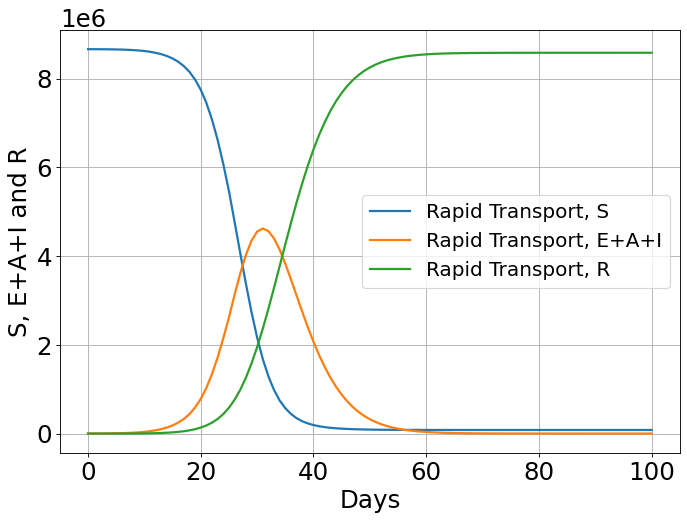

In [8]:
fig = plt.figure(num=None, figsize=(10,7), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 22})

total_w = 0.0
total_r = 0.0
for i in range(Nd):
    total_w += Nw[M,i]
    total_r += Nh[M,i]
print('Toatl', total_w, total_r)

S_total = []
E_total = []
A_total = []
I_total = []
#R_total = []
for i in range(len(S_MFT[0])):
    S_total.append(0.0)
    E_total.append(0.0)
    A_total.append(0.0)
    I_total.append(0.0)
    #R_total.append(0.0)
for i in range(M1):
    S_total  += S_MFT[i]
    E_total  += E_MFT[i]
    A_total  += A_MFT[i]
    I_total  += I_MFT[i]
plt.plot(t/24, S_total, '-', label='Rapid Transport, S', lw=2)
plt.plot(t/24, (E_total + A_total + I_total), '-', label='Rapid Transport, E+A+I', lw=2)
plt.plot(t/24, total_r - (S_total + E_total + A_total + I_total), '-', label='Rapid Transport, R', lw=2)
plt.legend(fontsize=18); plt.grid() 
plt.xlabel('Days')
plt.ylabel('S, E+A+I and R')
fig.savefig("London_EpidemicCurve.png")

f_data = open('network-SEAIR-MFT.txt', mode='w')
for i in range(len(t)):
    f_data.write(str(t[i]/24) + ' ' + str(S_total[i]) + ' ' + str(E_total[i]) + ' ' + str(A_total[i]) + ' ' + str(I_total[i]) + '\n')
f_data.close()

In [9]:
import pickle
import tempfile
#import geopandas as gpd
from geopandas.plotting import plot_polygon_collection
from matplotlib import animation

# Simulation data


N_ = np.zeros((len(t), Nd))
for tt in range(len(t)):
        for n in range(Nd):
            N_[tt, n] = Nh[M,n]

#Rapid transport
S_MFT_ = np.sum(mft_community_data[:,:,0,:], axis=1)
E_MFT_ = np.sum(mft_community_data[:,:,1,:], axis=1)
A_MFT_ = np.sum(mft_community_data[:,:,2,:], axis=1)
I_MFT_ = np.sum(mft_community_data[:,:,3,:], axis=1)
R_MFT_ = np.sum(mft_community_data[:,:,4,:], axis=1)

s_mft_ = S_MFT_ / N_
e_mft_ = E_MFT_ / N_
a_mft_ = A_MFT_ / N_
i_mft_ = I_MFT_ / N_
r_mft_ = R_MFT_ / N_

ts_days = t/24

# Load geometry

geometry_node_key = 'msoa11cd'
geometry = gpd.read_file("shape/Middle_Layer_Super_Output_Areas_December_2011_Boundaries_EW_BGC.shp")

loc_table = pd.read_csv('london_simulation/loc_table.csv')
loc_table_loc_col = loc_table.columns[0]
loc_table_loc_key_col = loc_table.columns[1]

geometry = geometry[ geometry[geometry_node_key].isin(loc_table.iloc[:,1]) ] # Remove locations in geometry that are not in loc_table
geometry = geometry.merge(loc_table, left_on=geometry_node_key, right_on=loc_table_loc_key_col) # Add location indices
geometry = geometry.sort_values(by=loc_table_loc_col) # Sort them by location indices

# Edit this function to adjust the layout of the video

def plot_frame(ti, close_plot=False, tmp_save=None):
    fig, axes = plt.subplots(ncols=3, nrows=2, gridspec_kw={'width_ratios':[1, 1, 1.3]}, figsize=(18, 14))

    geometry['S'] = s_[ti,:]
    geometry['E'] = e_[ti,:]
    geometry['A'] = a_[ti,:]
    geometry['I'] = i_[ti,:]
    geometry['R'] = r_[ti,:]
    
    plot_geo(geometry, axes[0,0], vmin=0, vmax=1, value_key='S', title="Susceptible", legend=False)
    plot_geo(geometry, axes[0,1], vmin=0, vmax=1, value_key='E', title="Exposed", legend=False)
    plot_geo(geometry, axes[0,2], vmin=0, vmax=1, value_key='A', title="Activated", legend=True)
    plot_geo(geometry, axes[1,0], vmin=0, vmax=1, value_key='I', title="Infected", legend=False)
    plot_geo(geometry, axes[1,1], vmin=0, vmax=1, value_key='R', title="Recovered", legend=False)
    
    plot_epi(axes[1,2], ti, ts_days, epi_data, ['S','E','A','I','R'])
    
    fig.tight_layout(rect=[0, 0.03, 1, 0.92])
    fig.suptitle("SEAIR Model - Day %s" % ti, fontsize=18)
    
    if not tmp_save is None:
        plt.savefig(tmp_save.name + '/%s.png' % ti)
    if close_plot:
        plt.close(fig)
    if not tmp_save is None:
        return tmp_save.name + '/%s.png' % ti

# Helper functions for plotting

def plot_geo(geometry, ax, vmin, vmax, value_key='val', title="", legend=True, legend_label='', cax=None, axis_on=False):
    if legend:
        if cax is None:
            geometry.plot(column=value_key, ax=ax, vmin=vmin, vmax=vmax, legend=True, legend_kwds={'label': legend_label})
        else:
            geometry.plot(column=value_key, ax=ax, cax=cax, vmin=vmin, vmax=vmax, legend=True, legend_kwds={'label': legend_label})
    else:
        geometry.plot(column=value_key, ax=ax, cax=cax, vmin=vmin, vmax=vmax, legend=False)
        
    ax.set_title(title)
    if not axis_on:
        ax.set_axis_off()
        
def plot_epi(ax, ti, ts, epi_data, epi_data_labels):
    for oi in range(epi_data.shape[0]):
        ax.plot(ts[:ti], epi_data[oi,:ti], label=epi_data_labels[oi])
    ax.legend(loc='center left')
    
    ax.set_xlim(np.min(ts_days), np.max(ts_days))
    ax.set_ylim(0, np.max(epi_data))

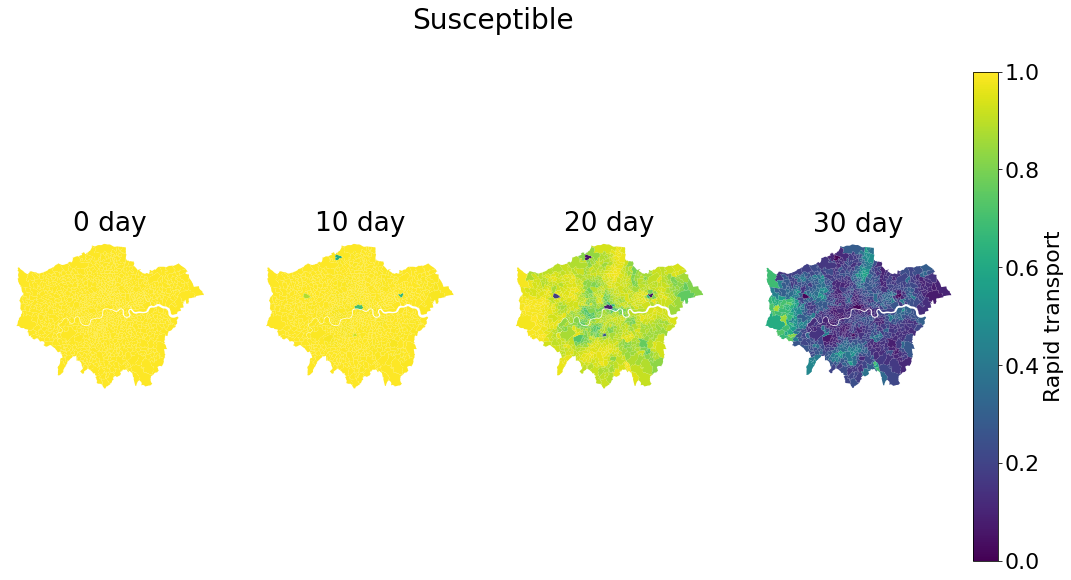

In [10]:
fig, axes = plt.subplots(ncols=4, nrows=1, gridspec_kw={'width_ratios':[1, 1, 1, 1.24]}, figsize=(18, 9))

fig.suptitle('Susceptible', fontsize=28)

dday = 10

geometry['R0'] = s_mft_[0*dday,:]
geometry['R10'] = s_mft_[1*dday,:]
geometry['R20'] = s_mft_[2*dday,:]
geometry['R30'] = s_mft_[3*dday,:]
    
plot_geo(geometry, axes[0], vmin=0, vmax=1, value_key='R0', title='%s day' % (0*dday), legend=False)
plot_geo(geometry, axes[1], vmin=0, vmax=1, value_key='R10', title='%s day' % (1*dday), legend=False)
plot_geo(geometry, axes[2], vmin=0, vmax=1, value_key='R20', title='%s day' % (2*dday), legend=False)
plot_geo(geometry, axes[3], vmin=0, vmax=1, value_key='R30', title='%s day' % (3*dday), legend=True, legend_label='Rapid transport')
fig.savefig('Susceptible.png')

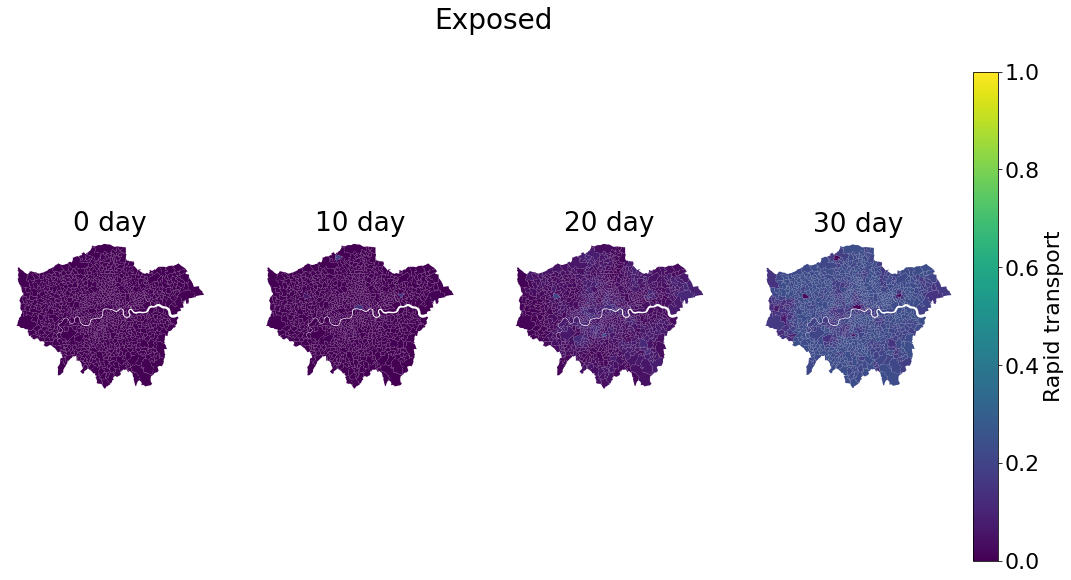

In [11]:
fig, axes = plt.subplots(ncols=4, nrows=1, gridspec_kw={'width_ratios':[1, 1, 1, 1.24]}, figsize=(18, 9))

fig.suptitle('Exposed', fontsize=28)

geometry['R0'] = e_mft_[0*dday,:]
geometry['R10'] = e_mft_[1*dday,:]
geometry['R20'] = e_mft_[2*dday,:]
geometry['R30'] = e_mft_[3*dday,:]

plot_geo(geometry, axes[0], vmin=0, vmax=1, value_key='R0', title='%s day' % (0*dday), legend=False)
plot_geo(geometry, axes[1], vmin=0, vmax=1, value_key='R10', title='%s day' % (1*dday), legend=False)
plot_geo(geometry, axes[2], vmin=0, vmax=1, value_key='R20', title='%s day' % (2*dday), legend=False)
plot_geo(geometry, axes[3], vmin=0, vmax=1, value_key='R30', title='%s day' % (3*dday), legend=True, legend_label='Rapid transport')
fig.savefig('Exposed.png')

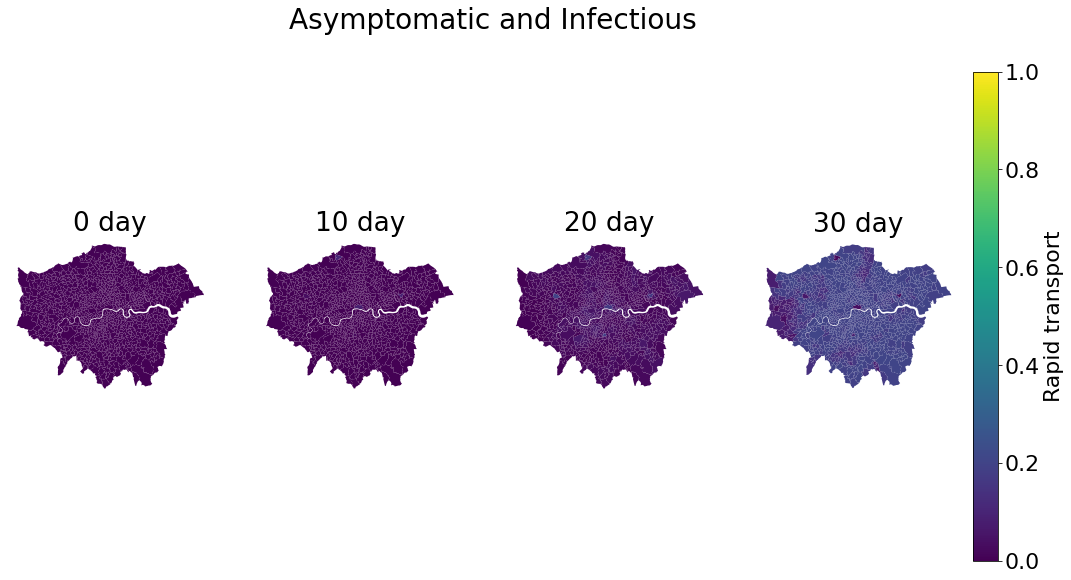

In [12]:
fig, axes = plt.subplots(ncols=4, nrows=1, gridspec_kw={'width_ratios':[1, 1, 1, 1.24]}, figsize=(18, 9))

fig.suptitle('Asymptomatic and Infectious', fontsize=28)

geometry['R0'] = a_mft_[0*dday,:]
geometry['R10'] = a_mft_[1*dday,:]
geometry['R20'] = a_mft_[2*dday,:]
geometry['R30'] = a_mft_[3*dday,:]
    
plot_geo(geometry, axes[0], vmin=0, vmax=1, value_key='R0', title='%s day' % (0*dday), legend=False)
plot_geo(geometry, axes[1], vmin=0, vmax=1, value_key='R10', title='%s day' % (1*dday), legend=False)
plot_geo(geometry, axes[2], vmin=0, vmax=1, value_key='R20', title='%s day' % (2*dday), legend=False)
plot_geo(geometry, axes[3], vmin=0, vmax=1, value_key='R30', title='%s day' % (3*dday), legend=True, legend_label='Rapid transport')
fig.savefig('Asymptomatic.png')

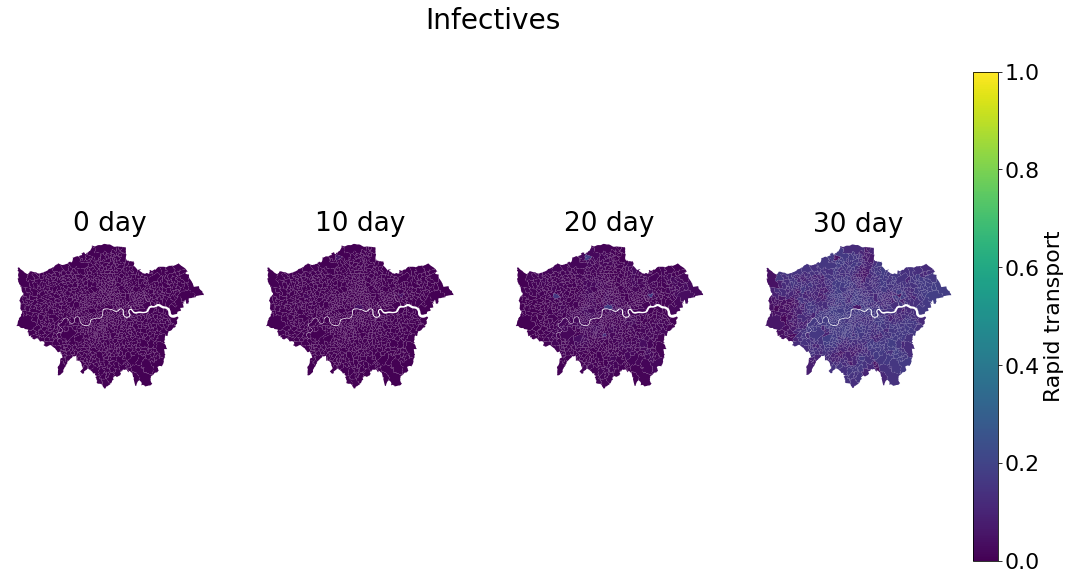

In [13]:
fig, axes = plt.subplots(ncols=4, nrows=1, gridspec_kw={'width_ratios':[1, 1, 1, 1.24]}, figsize=(18, 9))

fig.suptitle('Infectives', fontsize=28)

geometry['R0'] = i_mft_[0*dday,:]
geometry['R10'] = i_mft_[1*dday,:]
geometry['R20'] = i_mft_[2*dday,:]
geometry['R30'] = i_mft_[3*dday,:]
    
plot_geo(geometry, axes[0], vmin=0, vmax=1, value_key='R0', title='%s day' % (0*dday), legend=False)
plot_geo(geometry, axes[1], vmin=0, vmax=1, value_key='R10', title='%s day' % (1*dday), legend=False)
plot_geo(geometry, axes[2], vmin=0, vmax=1, value_key='R20', title='%s day' % (2*dday), legend=False)
plot_geo(geometry, axes[3], vmin=0, vmax=1, value_key='R30', title='%s day' % (3*dday), legend=True, legend_label='Rapid transport')
fig.savefig('Infectives.png')

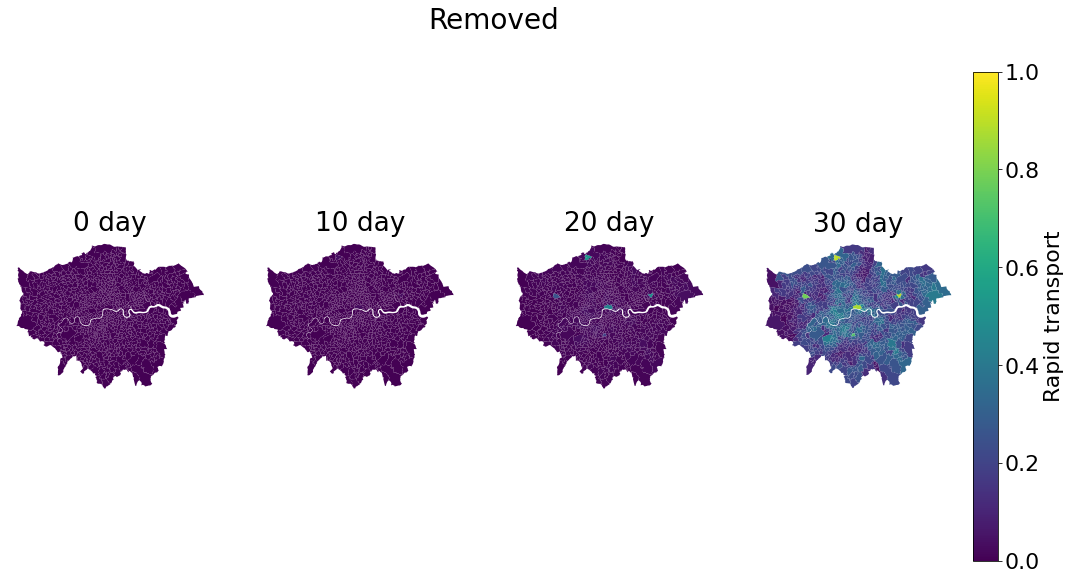

In [14]:
fig, axes = plt.subplots(ncols=4, nrows=1, gridspec_kw={'width_ratios':[1, 1, 1, 1.24]}, figsize=(18, 9))

fig.suptitle('Removed', fontsize=28)

geometry['R0'] = r_mft_[0*dday,:]
geometry['R10'] = r_mft_[1*dday,:]
geometry['R20'] = r_mft_[2*dday,:]
geometry['R30'] = r_mft_[3*dday,:]
    
plot_geo(geometry, axes[0], vmin=0, vmax=1, value_key='R0', title='%s day' % (0*dday), legend=False)
plot_geo(geometry, axes[1], vmin=0, vmax=1, value_key='R10', title='%s day' % (1*dday), legend=False)
plot_geo(geometry, axes[2], vmin=0, vmax=1, value_key='R20', title='%s day' % (2*dday), legend=False)
plot_geo(geometry, axes[3], vmin=0, vmax=1, value_key='R30', title='%s day' % (3*dday), legend=True, legend_label='Rapid transport')
fig.savefig('Removed.png')